# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [1]:
%matplotlib inline
import numpy as np
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [2]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

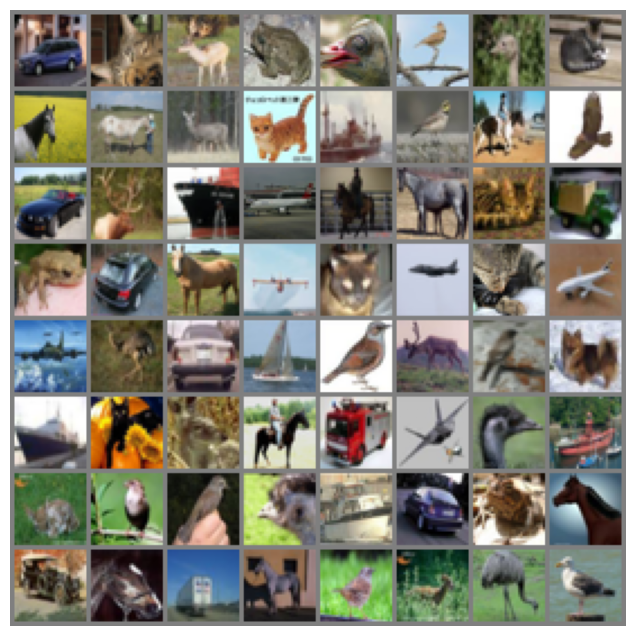

In [4]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [119]:
channels, height, width = images.shape[1:]
n_features = channels * height * width


class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        # Your code here!
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=10,
                               kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=25,
                               kernel_size=(5, 5))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv3 = nn.Conv2d(in_channels=25, out_channels=25,
                               kernel_size=(5, 5))
        self.conv4 = nn.Conv2d(in_channels=25, out_channels=25,
                               kernel_size=(5, 5))
        
        self.fc1 = nn.Linear(in_features=25*2*2, out_features=200)
        self.fc2 = nn.Linear(in_features=200, out_features=100)
        self.fc3 = nn.Linear(in_features=100, out_features=50)
        self.fc4 = nn.Linear(in_features=50, out_features=self.num_classes)
        

    def forward(self, x):
        # Your code here!
        x = self.conv1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv3(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


model = Model(n_classes)
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
print(model)

Model(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 25, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(25, 25, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(25, 25, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=100, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=10, bias=True)
)


## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [120]:
loss_fn = nn.CrossEntropyLoss() # Your code here!
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6) # Your code here!


## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [121]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[ 0.05640989  0.05793936  0.06663872  0.13215888 -0.00809277 -0.12270076
   0.03077345  0.10561535 -0.12058166 -0.00774901]
 [ 0.05566281  0.05991415  0.06622339  0.13094835 -0.00544231 -0.12487472
   0.03166911  0.10779443 -0.12337952 -0.00998265]]
Output probabilities:
[[0.10346806 0.10362643 0.10453185 0.11161014 0.09700479 0.08650068
  0.10084922 0.10868659 0.08668418 0.09703813]
 [0.10340242 0.10384295 0.1045002  0.11148766 0.09727317 0.08632255
  0.10095093 0.10893593 0.08645172 0.09683252]]


In [122]:

batch_size = 64
num_epochs = 50
validation_every_steps = 500

wandb.init(project="deeplearning_week4", config={
    "batch_size": batch_size,
    "num_epochs": num_epochs,
    "validation_every_steps": validation_every_steps,
    "learning_rate": optimizer.param_groups[0]['lr']  
})

step = 0
model.train()

train_accuracies = []
train_loss = []
valid_accuracies = []
valid_loss = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    train_loss_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        train_loss_batches.append(loss.item())
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            train_loss.append(torch.mean(torch.tensor(train_loss_batches)))
            
            train_accuracies_batches = []
            train_loss_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            valid_loss_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))
                    valid_loss_batches.append(loss.item())

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
            valid_loss.append(torch.sum(torch.tensor(valid_loss_batches)) / len(test_set))

            wandb.log({
                "train_loss": train_loss[-1],
                "train_accuracy": train_accuracies[-1],
                "valid_loss": valid_loss[-1],
                "valid_accuracies": valid_accuracies[-1]
            }, step=step)

            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

train_accuracy,▁▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████
train_loss,█▇▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
valid_accuracies,▁▁▂▃▃▃▄▅▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████
valid_loss,█▇▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.74162
train_loss,0.74143
valid_accuracies,0.6553
valid_loss,0.0156


Step 500     training accuracy: 0.1979375
             test accuracy: 0.2502
Step 1000    training accuracy: 0.33307052752293576
             test accuracy: 0.346
Step 1500    training accuracy: 0.34784375
             test accuracy: 0.3586
Step 2000    training accuracy: 0.3791212729357798
             test accuracy: 0.3859
Step 2500    training accuracy: 0.40594561688311687
             test accuracy: 0.4058
Step 3000    training accuracy: 0.41875
             test accuracy: 0.4322
Step 3500    training accuracy: 0.439432123655914
             test accuracy: 0.4549
Step 4000    training accuracy: 0.4609375
             test accuracy: 0.4592
Step 4500    training accuracy: 0.46546875
             test accuracy: 0.4722
Step 5000    training accuracy: 0.4830560064935065
             test accuracy: 0.4906
Step 5500    training accuracy: 0.4873798076923077
             test accuracy: 0.4912
Step 6000    training accuracy: 0.499375
             test accuracy: 0.5046
Step 6500    training a

## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

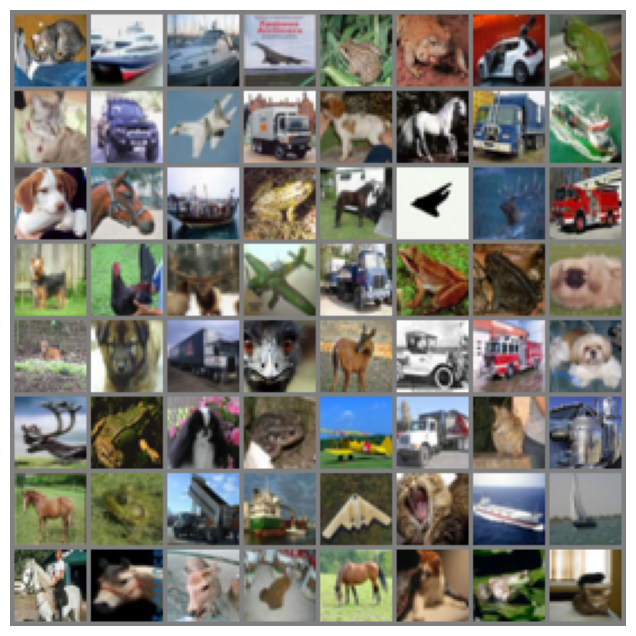

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship          ship     
    ship          ship     
  airplane      airplane   
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          frog     
     cat           cat     
 automobile    automobile  
  airplane         cat     
    truck         truck    
     dog           dog     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse          cat     
    ship          ship     
    frog          frog     
    horse         horse    
  airplane        bird     
    deer          deer     
    truck         truck    
     dog          deer     
    bird          bird     
    deer          deer     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog           dog     
    deer          bird     
     dog           c

In [126]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [123]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [124]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.679


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


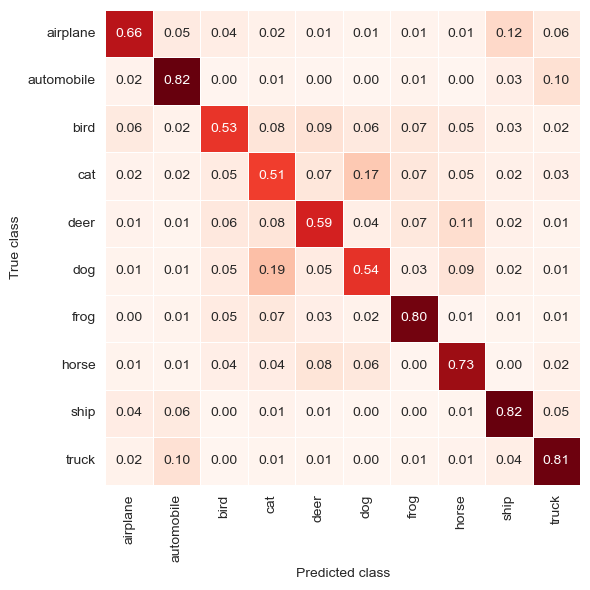

In [125]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

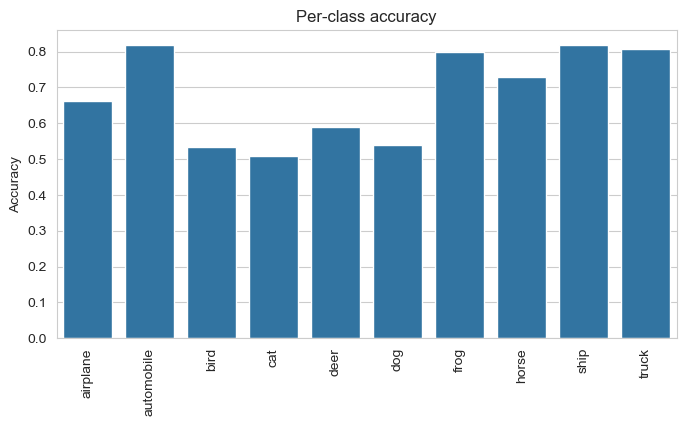

In [127]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.

**Answer:**

Here is my first try model with lr=1e-4, epoch 10 \
Model( \
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)) \
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)) \
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False) \
  (fc1): Linear(in_features=400, out_features=120, bias=True) \
  (fc2): Linear(in_features=120, out_features=60, bias=True) \
  (fc3): Linear(in_features=60, out_features=10, bias=True) \
) \
and the test accuracy is 0.511 

If the same model but increase epoch to 50, the test accuracy is 0.610 

If we add another linear layer, with lr=1e-4, epoch 50 \
Model( \
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1)) \
  (conv2): Conv2d(10, 25, kernel_size=(5, 5), stride=(1, 1)) \
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False) \
  (fc1): Linear(in_features=625, out_features=200, bias=True) \
  (fc2): Linear(in_features=200, out_features=100, bias=True) \
  (fc3): Linear(in_features=100, out_features=50, bias=True) \
  (fc4): Linear(in_features=50, out_features=10, bias=True) \
) 
and the test accuracy is 0.660


Here is my third try model with lr=1e-4, epoch 30 \
Model( \
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1)) \ 
  (conv2): Conv2d(10, 25, kernel_size=(5, 5), stride=(1, 1)) \
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False) \
  (conv3): Conv2d(25, 25, kernel_size=(5, 5), stride=(1, 1)) \
  (conv4): Conv2d(25, 25, kernel_size=(5, 5), stride=(1, 1)) \
  (fc1): Linear(in_features=100, out_features=200, bias=True) \
  (fc2): Linear(in_features=200, out_features=100, bias=True) \
  (fc3): Linear(in_features=100, out_features=50, bias=True) \
  (fc4): Linear(in_features=50, out_features=10, bias=True) \
)
and the test accuracy is 0.679

![Example Image](modelreport.png)

After those experiment, 1.increasing epochs can have higher accuracy, 2.increase the layer(linear or convolution layer) can helps the accuracy. Changing he learning rates and weight_decay or add batch normalization might also helps.

My insight is epoches, and model architechure can influence the accuracy. Also, Even though in the model that has a higher training accuracy doesn't mean to have a higher test accuracy. 



# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [ ]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

**Answer:**





The exercise i chose is from CHAPTER 3:Improving the way neural networks learn \
Q. What would go wrong if we used μ>1 in the momentum technique? What would go wrong if we used μ<0 in the momentum technique?

Since the friction in the system is represented by 1−𝜇, if 𝜇>1, the friction becomes negative. This means that instead of moving forward, gradient descent would start moving in the wrong direction. On the other hand, if μ<0, the friction exceeds 1, which disrupts the balance of energy in the system. As a result, gradient descent might overshoot and fail to find a local minimum.